Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dev Accuracy: 0.7682315405651777

📋 Dev Classification Report:
                                       precision    recall  f1-score   support

                       Not_offensive       0.80      0.97      0.87      3193
     Offensive_Targeted_Insult_Group       0.41      0.14      0.21       295
Offensive_Targeted_Insult_Individual       0.45      0.13      0.21       307
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        65
               Offensive_Untargetede       0.45      0.24      0.31       356
                           not-Tamil       0.87      0.63      0.73       172

                            accuracy                           0.77      4388
                           macro avg       0.50      0.35      0.39      4388
                        weighted avg       0.71      0.77      0.72      4388



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


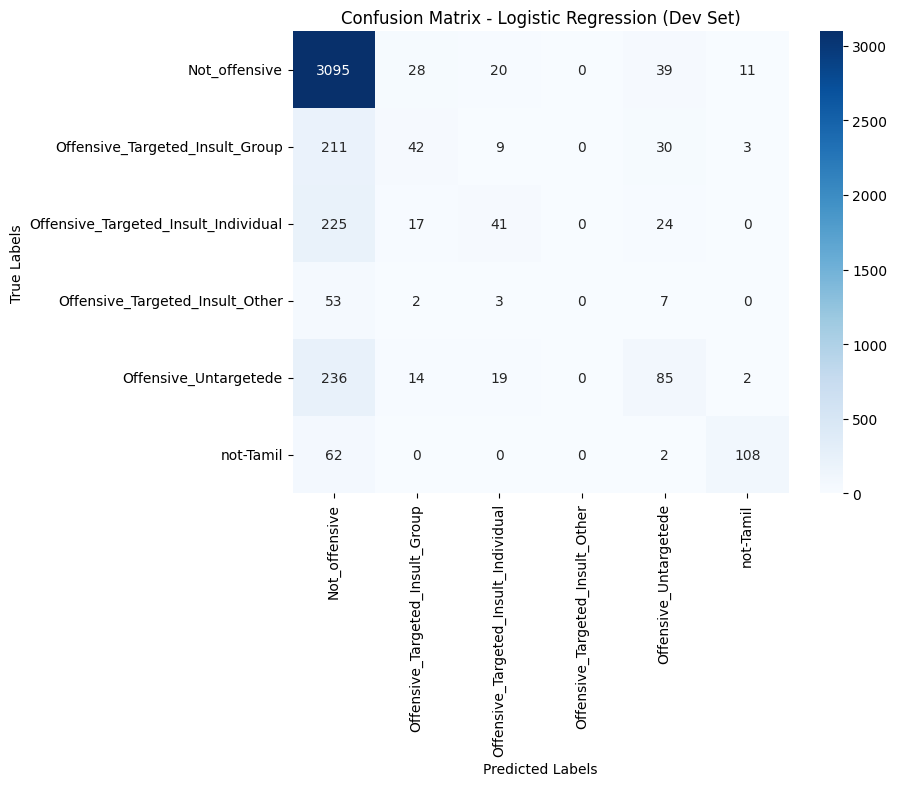

✅ Test predictions saved to: /content/drive/MyDrive/Dataset/Tamil/tamil_LogisticRegression_Results.csv


In [2]:
# Logistic Regression
# ==========================================================

import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1. Mount Google Drive =====
from google.colab import drive
drive.mount('/content/drive')

# ===== 2. Load CSVs =====
train_path = "/content/drive/MyDrive/Dataset/Tamil/tamil_offensive_full_train.csv"
dev_path   = "/content/drive/MyDrive/Dataset/Tamil/tamil_offensive_full_dev.csv"
test_path  = "/content/drive/MyDrive/Dataset/Tamil/tamil_offensive_test_without_labels.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# ===== 3. Preprocess text =====
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\u0B80-\u0BFF ]+', '', text)  # Keeps Tamil + English letters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['clean_text'] = df_train['Text'].apply(preprocess_text)
df_dev['clean_text']   = df_dev['Text'].apply(preprocess_text)
df_test['clean_text']  = df_test['Text'].apply(preprocess_text)

# ===== 4. Encode labels =====
label_encoder = LabelEncoder()
df_train['encoded_labels'] = label_encoder.fit_transform(df_train['Labels'])
df_dev['encoded_labels']   = label_encoder.transform(df_dev['Labels'])
if 'Labels' in df_test.columns:  # test usually has no labels
    df_test['encoded_labels'] = label_encoder.transform(df_test['Labels'])

# ===== 5. TF-IDF Vectorization =====
tfidf = TfidfVectorizer(max_features=1500)
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
X_dev_tfidf   = tfidf.transform(df_dev['clean_text'])
X_test_tfidf  = tfidf.transform(df_test['clean_text'])

# ===== 6. Train Logistic Regression =====
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, df_train['encoded_labels'])

# ===== 7. Evaluate on dev set =====
y_pred_dev = model.predict(X_dev_tfidf)
accuracy_dev = accuracy_score(df_dev['encoded_labels'], y_pred_dev)
print("✅ Dev Accuracy:", accuracy_dev)
print("\n📋 Dev Classification Report:\n",
      classification_report(df_dev['encoded_labels'], y_pred_dev, target_names=label_encoder.classes_))

# ===== 7b. Confusion Matrix =====
cm = confusion_matrix(df_dev['encoded_labels'], y_pred_dev)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Logistic Regression (Dev Set)")
plt.show()

# ===== 8. Predict on test set =====
y_pred_test = model.predict(X_test_tfidf)
df_test['labels'] = label_encoder.inverse_transform(y_pred_test)

# ===== 9. Save predictions (only ID + labels) =====
if 'ID' not in df_test.columns:
    # If no 'ID' column, generate sequential IDs
    df_test['ID'] = range(1, len(df_test) + 1)

output = df_test[['ID', 'labels']]

output_path = "/content/drive/MyDrive/Dataset/Tamil/tamil_LogisticRegression_Results.csv"
output.to_csv(output_path, index=False)

print(f"✅ Test predictions saved to: {output_path}")
